# cleanup data and store for latter processing

To do:

- drifters: 
    - [X] maps of trajectories
    - [X] trajectories in relative frame of reference
    - [X] relative dispersion
    - [ ] produce movies of trajectories
    - [ ] produce movies of relative evolution
- finish clean up ctd: 
    - [X] mecanism to distinguish between underway and cast
    - [ ] ask confirmation that we don't have more to Benji
- add wind information:
    - [X] arome
    - [ ] wind station (got it but need to be processed)
- go get tide information (currents, sea level):
    - [X] tide gauge Ouistreham
    - [ ] SMILE ADCP data (waiting
- satellite data: S2, SST
    - [ ] ask
    - [ ] process


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

# cognac data and tools
#import cognac.insitu as iu
import pynsitu as pin

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
#campaign="taos0_drifters0"
#yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
campaign="taos0_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.campaign(os.path.join(root_dir,yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_parceque
ctd_hydrophone
ship_hydrophone
ship_parceque


---

## ctd, underway, cast

Very convenient the GPS logging !

**taos0 - drifters0**

- First day, the first ctd deployment (d0) is noisy for salinity with fluctuations with period of less that 10s. Do we see this for other deployments? We apply a median filter for now
- Second day: salinity is less noisy

**taos0 - drifters1**

- First day - hydrophone: 
    - no gps position during half of first cast: ctd turned on too late?
    - takes about 45s for the conductivity to reach equilibrium, several downcast did not wait long enough
   
Keep only downcast (because slower than upcast) for CTD profiless


In [3]:
def read_sonde_lern(file, tz_offset=0, stype=0):
    """ Load LERN CTD data
    """
    
    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace('\x00', '').strip().replace(",",".").split('\t') for v in d]

    # remove some empty rows
    d = [v for v in d if len(v) > 1]
    
    #d[0]:
    #['Date', 'Time', 'Site', 'Unit ID', 'User ID',
    # '°C-19K104425', 'mmHg-19C102825', 'DO %-20A103151', 'DO mg/L-20A103151', 
    # 'C-mS/cm-19K104425', 'SAL-PSU-19K104425', 'FNU-19M102353',
    # 'Chl RFU-19M101982', 'Chl ug/L-19M101982',
    # 'DEP m-19K105267']

    # benji deployments
    # ['Date', 'Time', 'Site', 'Unit ID', 'User ID', 
    # '°C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 
    # 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 
    # 'DEP m-20H100561']

    if stype==0:
        columns = ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
         'temperature', 'air_pressure', 'DO_p', 'DO_mgL', 
         'conductivity', 'salinity', 'FNU',
         'Chl_RFU', 'Chl_ugL',
         'depth', 'latitude', 'longitude']
    elif stype==1:
        columns = ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
         'temperature', 'air_pressure', 'DO_p', 'DO_mgL', 
         'conductivity', 'salinity',
         'depth', 'latitude', 'longitude']

    df = pd.DataFrame(d[1:], columns=columns)
    
    # convert column 0 and 1 to a datetime
    df['time'] = pd.to_datetime(df["Date"] + ' ' + df["Time"]) + pd.Timedelta("1H")*tz_offset

    df.set_index("time", inplace=True)
    df = df.drop(columns=["Date", "Time", "Site", "Unit ID", "User ID"])

    df = df.astype('float')

    # convert air pressure from mmHg to bar
    df["air_pressure"] = df["air_pressure"]/750.06
    
    # bad longitude, latitude values are 0.0
    df.loc[:, "longitude"] = df.loc[:, "longitude"].where(df.loc[:, "longitude"] != 0.)
    df.loc[:, "latitude"] = df.loc[:, "latitude"].where(df.loc[:, "latitude"] != 0.)

    return df

**Parceque**

In [18]:
u, stype = "ctd_parceque", 0 # franck - check
despike=False

case=2
if case==0:
    # taos0-drifters0, day 0
    assert campaign=="taos0_drifters0", "campaign should be taos0_drifters0"
    ctd_path = os.path.join(cp.pathr, u+"_11052022.csv")
    labels = [f"u{i}" for i in range(4)]
    despike=True
elif case==1:
    # taos0-drifters0, day 1
    assert campaign=="taos0_drifters0", "campaign should be taos0_drifters0"
    ctd_path = os.path.join(cp.pathr, u+"_13052022.csv")
    labels = ["u4", "c5", "c6"]
elif case==2:
    # taos0-drifters1, day 0
    assert campaign=="taos0_drifters1", "campaign should be taos0_drifters1"
    ctd_path = os.path.join(cp.pathr, u+"_17052022.csv")
    labels = ["u0"]
elif case==3:
    # taos0-drifters1, day 1
    assert campaign=="taos0_drifters1", "campaign should be taos0_drifters"
    ctd_path = os.path.join(cp.pathr, u+"_19052022.csv")
    labels = ["u1"]

**Hydrophone**

In [4]:
u, stype = "ctd_hydrophone", 1 # benji

case=2
if case==0:
    raise AttributeError("not a valid case")
    # taos0-drifters0, day 0  !!! no valid CTD
elif case==1:
    raise AttributeError("not a valid case")
    # taos0-drifters0, day 1  !!! no valid CTD
elif case==2:
    # taos0-drifters1, day 0
    ctd_path = os.path.join(cp.pathr, u+"_17052022.csv")
    labels = [f"c{i}" for i in range(15)]
elif case==3:
    # taos0-drifters1, day 1
    ctd_path = os.path.join(cp.pathr, u+"_19052022.csv")
    labels = [f"c{i}" for i in range(15,23)]

In [5]:
df = read_sonde_lern(ctd_path, tz_offset=-2, stype=stype)

# rule=None -> raw data
df.sw.plot_bokeh(unit=cp[u], cross=False)

Loading BokehJS ...

### plot raw salinity and diff to identify spikes

May be skipped if data is known not to have noisy salinity

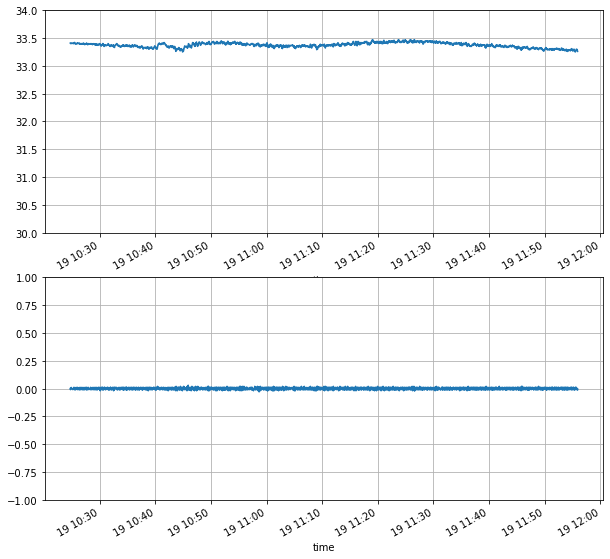

In [13]:
def plot_salinity(df, **kwargs):

    fig, axes = plt.subplots(2,1, figsize=(10,10))
    ax = axes[0]
    df.salinity.plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([30,34])

    ax = axes[1]
    df.salinity.diff().plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([-1,1])

plot_salinity(df)

fractions of salinity difference (with smoothed salinity) lower than 0.2 psu = 100.0%


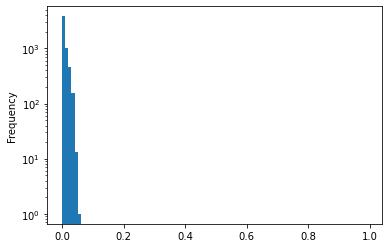

In [14]:
# salinity smoothing
rule = "10s" # 20s at 2m/s is 40m
dsalinity_threshold = 0.2

fig, ax = plt.subplots(1,1)
dfs = df.rolling(window=rule).median()
ds = df.salinity-dfs.salinity
np.abs(ds).plot.hist(bins=np.arange(0,1,.01), ax=ax)
ax.set_yscale("log")

_frac = (ds.loc[np.abs(ds)<dsalinity_threshold].index.size / ds.index.size)
print(f"fractions of salinity difference (with smoothed salinity) lower than {dsalinity_threshold} psu = {_frac*100:.1f}%")

### plot one cast time series

Search to highlight casts quality

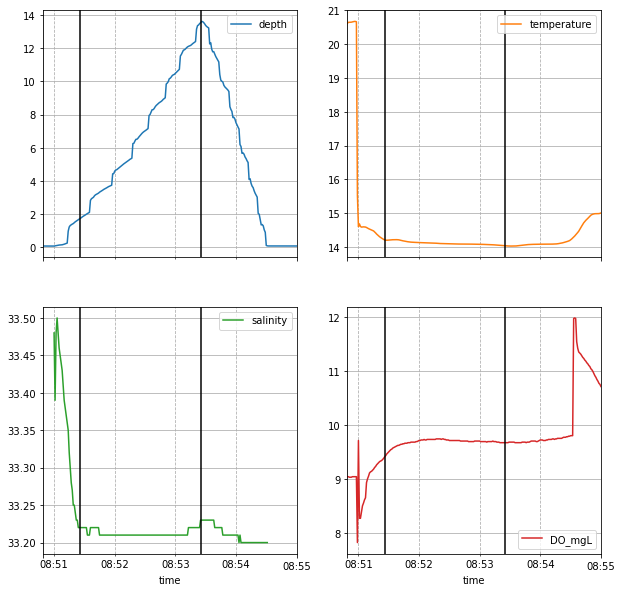

In [51]:
_df = df.loc["2022-05-17 08:50:00":"2022-05-17 08:55:00"]
d = cp["ctd_hydrophone"]["c6"]

_df = _df.loc[:,["depth", "temperature", "salinity", "DO_mgL"]]
_df["salinity"] = _df["salinity"].where(_df["salinity"]>30)

axes = _df.plot(subplots=True, figsize=(10,10), grid=True, layout=(2,2))
for ax in axes.flatten():
    ax.grid(which='minor', axis='both', linestyle='--')
    ax.axvline(d.start.time, color="k")
    ax.axvline(d.end.time, color="k")

# trim, filter and store

In [12]:
# transect parameters
ds = 20. # m, spacing
vmin=0.5 # m/s, tune search parameter

s_vars = ["salinity", "conductivity", "SA"]

D = {}
for d in cp[u]:
    if (isinstance(labels, str) and labels=="all") or d.label in labels:
        # trim first to exclude irrelevant values
        _df = df.sw.trim(d)
        if d.label[0]=="u":
            # underway data
            print(d, "underway processing")
            ## simple temporal average
            #_df = _df.sw.resample("20s", op="median")
            ## despike salinity
            if despike:
                #_df = _df.loc[ np.abs(_df.salinity.diff())<0.1 ]
                _dfs = _df.rolling(window=rule).median() 
                _ds = _df.salinity - _dfs.salinity
                _df.loc[np.abs(_ds) > dsalinity_threshold, s_vars] = np.NaN
                # interpolate gaps
                _df.loc[:, s_vars] = _df.loc[:, s_vars].interpolate(method="linear")
            ## interpolate on a regularly sampled transect
            _df = _df.geo.compute_transect(ds, vmin=vmin)
            # update temperature, salinity and sigma0 from PA, CT
            _df = _df.sw.update_eos()
        elif d.label[0]=="c":
            print(d, "cast processing")
            _df = _df.sw.compute_vertical_profile(1.)
            _df = _df.sw.update_eos()
        D[d.label] = _df
    else:
        print(f"skipping {d.label}")

c0 / start 2022-05-17 07:31:00 -0.24 49.34 / end 2022-05-17 07:37:40 -0.24 49.34 cast processing
c1 / start 2022-05-17 07:44:40 -0.26 49.33 / end 2022-05-17 07:50:50 -0.26 49.33 cast processing
c2 / start 2022-05-17 08:00:26 -0.25 49.34 / end 2022-05-17 08:03:06 -0.25 49.34 cast processing


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexes/base.py:2618: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'float', sort order is undefined for incomparable objects
  return Index.union(this, other, sort=sort).astype(object, copy=False)


c3 / start 2022-05-17 08:05:00 -0.25 49.34 / end 2022-05-17 08:10:40 -0.25 49.34 cast processing
c4 / start 2022-05-17 08:14:38 -0.25 49.34 / end 2022-05-17 08:18:16 -0.25 49.34 cast processing
c5 / start 2022-05-17 08:24:33 -0.23 49.34 / end 2022-05-17 08:27:47 -0.23 49.34 cast processing
c6 / start 2022-05-17 08:51:26 -0.24 49.32 / end 2022-05-17 08:53:25 -0.24 49.32 cast processing
c7 / start 2022-05-17 08:56:57 -0.24 49.32 / end 2022-05-17 08:59:46 -0.24 49.32 cast processing
c8 / start 2022-05-17 09:03:17 -0.24 49.31 / end 2022-05-17 09:06:00 -0.24 49.31 cast processing
c9 / start 2022-05-17 09:08:39 -0.25 49.31 / end 2022-05-17 09:11:24 -0.25 49.31 cast processing
c10 / start 2022-05-17 09:13:52 -0.25 49.31 / end 2022-05-17 09:16:20 -0.25 49.31 cast processing
c11 / start 2022-05-17 09:19:02 -0.25 49.30 / end 2022-05-17 09:20:35 -0.25 49.30 cast processing
c12 / start 2022-05-17 09:23:00 -0.25 49.30 / end 2022-05-17 09:24:32 -0.25 49.30 cast processing
c13 / start 2022-05-17 09:2

In [ ]:
#_df = D["u0"] # drifters0 day0
#_df = D["u4"] # drifters0 day1
#_df = D["u"] # drifters1 day0
_df = D["u1"] # drifters1 day1

col_drop = ["time", "SA", "CT", "conductivity", "x", "y", "ux", "uy", "pressure", "DO_p", "Chl_RFU"]

_df.drop(columns=col_drop, errors="ignore").plot(subplots=True, figsize=(10,20), grid=True);

### store

In [15]:
for d, _df in D.items():
    _df.to_xarray().to_netcdf(os.path.join(cp.pathp, f'{u}_{d}.nc'), mode="w")

---

## ships


**taos0-drifters1:** Missing data files for second day

In [26]:
def load_ship(file, correct_day=None):
    """ load ship (hydrophone, parceque) data
    
    Parameters
    ----------
    file: str
        path to data file
    correct_day: tuple, optional
        fix day of first data point (year, month, day)
    """
    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace('\n', '').split(',') for v in d]

    columns = d[0]
    #print(columns)
    # ['ID', 'trksegID', 'lat', 'lon', 'ele', 'time', 'magvar', 'geoidheight', 'name', 'cmt', 'desc', 'src', 'sym', 'type', 'fix', 'sat', 'hdop', 'vdop', 'pdop', 'ageofdgpsdata', 'dgpsid', 'Temperature', 'Depth', 'wtemp', 'hr', 'cad', '']

    df = pd.DataFrame(d[1:], columns=columns)
    df["time"] = pd.to_datetime(df["time"])

    # fix day
    if correct_day:
        if isinstance(correct_day, dict):
            day = pd.Timestamp(**correct_day, tz="UTC")
        else:
            # assumes Timestamp
            day = correct_day
        t0 = df["time"][0]
        dt = day - t0.round("1D")
        print(f"Fix first time from {t0} to {t0 + dt}")
        df["time"] = (df["time"] + dt).dt.tz_localize(None) # drop timezone as well (xarray complications down the line)

    # only keep non zero columns
    selected_columns = ["time", "lon", "lat", "Depth", "Temperature"]
    df = (df[selected_columns]
          .set_index("time")
          .replace("","0")
          .astype('float')
    )
    
    # rename critical columns
    df = df.rename(columns=dict(lon="longitude", lat="latitude", Depth="water_depth", Temperature="air_temperature"))
    
    return df

In [32]:
deployments = [d.label for d in list(cp['ship_hydrophone'])]

d = deployments[0] # d0
#d = deployments[1] # d1
print(f"deployment {d}")

file_p = os.path.join(cp.pathr, cp['ship_parceque'][d].info["file"])
file_h = os.path.join(cp.pathr, cp['ship_hydrophone'][d].info["file"])

cday = dict(year=2022, month=5, day=11)
cday = cp['ship_parceque'][d].start.time.round("1D").tz_localize("UTC")

df_p = load_ship(file_p, correct_day=cday)
df_h = df = load_ship(file_h, correct_day=cday)

deployment d0
Fix first time from 2002-10-01 07:17:39+00:00 to 2022-05-17 07:17:39+00:00
Fix first time from 2002-10-01 07:33:15+00:00 to 2022-05-17 07:33:15+00:00


### store

In [33]:
for df, label in zip([df_h, df_p], ["hydrophone", "parceque"]):
    (df.to_xarray()
     .to_netcdf(os.path.join(cp.pathp, f'ship_{label}_{d}.nc'), mode="w")
    )

### plot

In [34]:
df_h.geo.plot_bokeh(unit=cp["ship_hydrophone"])
df_h.geo.plot_bokeh_map()

Loading BokehJS ...

Loading BokehJS ...

In [35]:
df_p.geo.plot_bokeh(unit=cp["ship_parceque"])
df_p.geo.plot_bokeh_map()

Loading BokehJS ...

Loading BokehJS ...

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


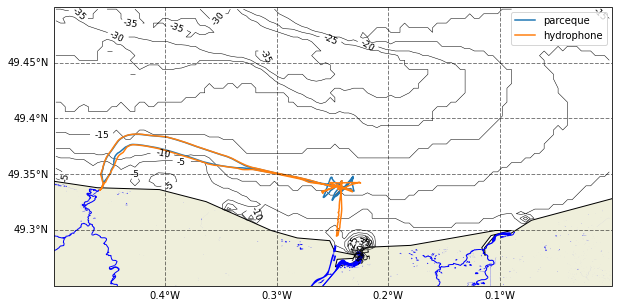

In [36]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-.5, .0, 49.25, 49.5]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

ax.plot(df_p.longitude, df_p.latitude, transform=crs, label="parceque")
ax.plot(df_h.longitude, df_h.latitude, transform=crs, label="hydrophone")

ax.legend()

Inspect typical time interval between ship positions.

Typically around 10 seconds

Text(0.5, 1.0, 'Time interval between positions in seconds')

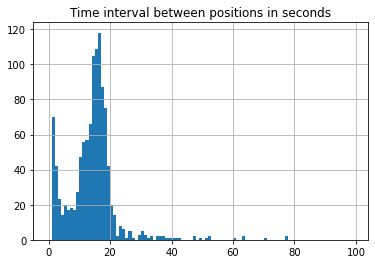

In [37]:
_df = df_p.reset_index()
_df["dt"] = _df["time"].diff()/pd.Timedelta("1s")
_df["dt"].hist(bins=np.arange(0,100,1))
plt.title("Time interval between positions in seconds")

---

## observed and modelled sea level and tidal currents

In [ ]:
import taos.utils as ut
dsh = ut.predict_tides(_ds.date_start, real=False, summed=False)

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [2]:
import xarray as xr
import pandas as pd
from glob import glob

In [3]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"


def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """ Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """
    
    t = pd.to_datetime(t)
    if dt is not None:
        t = [t+pd.Timedelta(days=_dt) for _dt in range(*dt)]
        t = pd.date_range(t[0],t[-1], freq=freq)
    else:
        t = [t]
    
    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath)) 
        _ds = xr.merge([xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files])
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [4]:
# taos0-drifters0
t = pd.Timestamp(2022,5,12)
label = "taos0-drifters0"
# taos0-drifters1
t = pd.Timestamp(2022,5,19)
label = "taos0-drifters1"

ds = load_arome(t, dt=(-30,5,), longitude=slice(-2,2), latitude=slice(48,50)).chunk(dict(time="auto"))

nc = os.path.join(os.getenv("SCRATCH"), label+"_arome.nc")
ds.to_netcdf(nc, mode="w")

### quick overview

In [5]:
ds = cp.load("arome.nc")

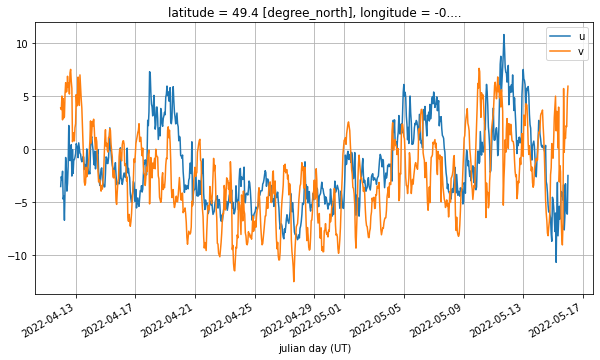

In [13]:
_ds = ds.sel(longitude=-0.2, latitude=49.4, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
ax.grid()
ax.set_ylabel("")
ax.legend()

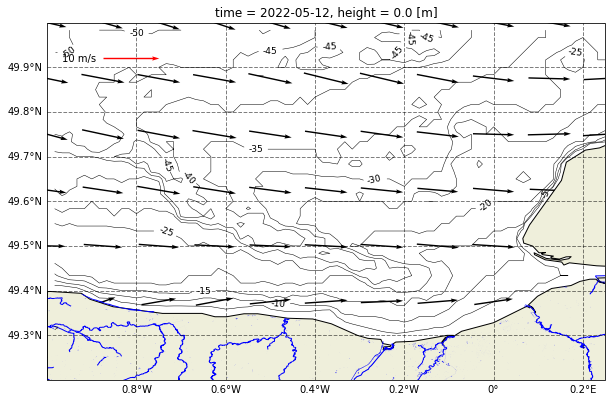

In [42]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-1., .25, 49.2, 50.]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

di=5
_ds = (ds.sel(time="2022-05-12 00:00:00")
       .isel(longitude=slice(0,None,di),latitude=slice(0,None,di))
      )

q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                  labelpos='W', coordinates='axes', zorder=10)

---

## river discharges

---

## tides, sea level/currents



In [3]:
tgauge_dir = "/Users/aponte/Data/tides/maregraphe"

In [4]:
from glob import glob
tgauge_files = sorted(glob(os.path.join(tgauge_dir, "*.nc")))

ds = xr.open_dataset(tgauge_files[-1])

ds = ds.rename(dict(TIME="time", 
                    LATITUDE="latitude", LONGITUDE="longitude",
                    Source1="sea_level",
                   )
              )

# demean sea level
ds["sea_level"] = ds["sea_level"] - ds["sea_level"].mean("time")

In [5]:
dt = (ds.time.diff("time")/pd.Timedelta("1s"))
print(f" min(dt)= {float(dt.min())} max(dt)= {float(dt.max())} ")

 min(dt)= 60.0 max(dt)= 10106.0 


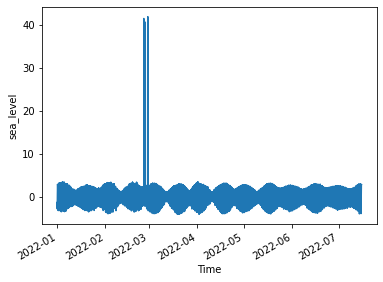

In [6]:
ds.sea_level.plot()

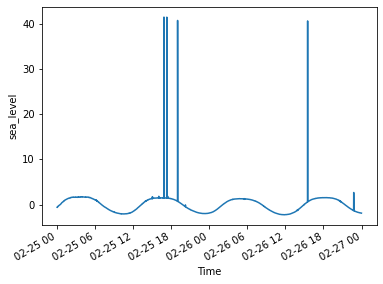

In [57]:
ds.sel(time=slice("2022-02-25","2022-02-26")).sea_level.plot()

In [43]:
#dsr = ds.sel(time=slice(cp.start - pd.Timedelta("10D"), cp.end + pd.Timedelta("10D"))).resample(time="10T").mean()
dsr = ds.sel(time="2022").resample(time="10T").mean()


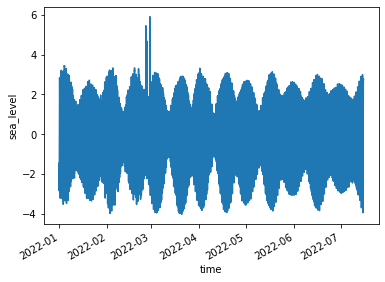

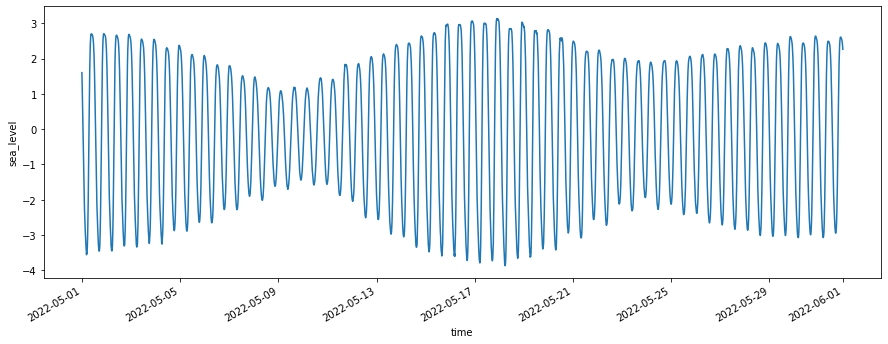

In [44]:
dsr.sea_level.sel(time="2022-05").plot(figsize=(15,5))

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:4: UserWarning: registration of accessor <class '__main__.TimeSeriesAccessor'> under name 'ts' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class TimeSeriesAccessor:


In [45]:
df = dsr.to_dataframe()
df.ts.time_physical()
df.head()

latitude  longitude  sea_level        timep
time                                                             
2022-01-01 00:00:00  49.279362   -0.24903  -1.461973  378691200.0
2022-01-01 00:10:00  49.279362   -0.24903  -1.644713  378691800.0
2022-01-01 00:20:00  49.279362   -0.24903  -1.793523  378692400.0
2022-01-01 00:30:00  49.279362   -0.24903  -1.939423  378693000.0
2022-01-01 00:40:00  49.279362   -0.24903  -2.078783  378693600.0

['M2', 'K1', 'S2', 'O1', 'P1', 'N2', 'K2', 'Q1', 'J1', 'L2', 'T2', '2N2', 'MN4', 'M4', 'MS4', 'M6', 'M3', 'R2', 'S1', 'S4', 'MKS2', 'N4', 'M8']


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:830: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))


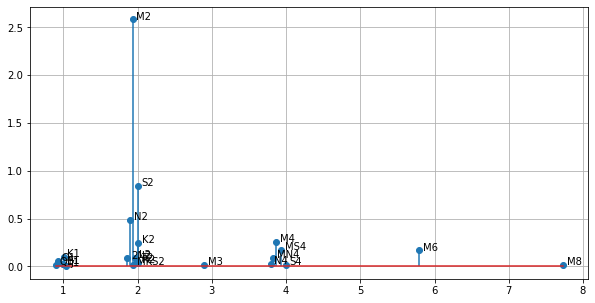

In [46]:
cst = ["O1", "K1", "M2", "S2"]

c = load_equilibrium_constituents()
cst = [c.upper() for c in list(c.sort_values("amplitude", ascending=False)
                               .iloc[:].index
                              )
      ]
cst = [c for c in cst if c not in ["MF", "MM", "SSA", "NU2", "MU2", "EPS2", "MSF", "LAMBDA2", "MSQM", "SA", "MTM"]]
print(cst)

#cst = cst + ["M4", "MS4"]

df.ts.tidal_analysis("sea_level", constituents=cst)

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:220: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v =  ( f * np.exp(1j*vu) * np.conj(har[:,None]) ).sum(axis=0)


<AxesSubplot:xlabel='time'>

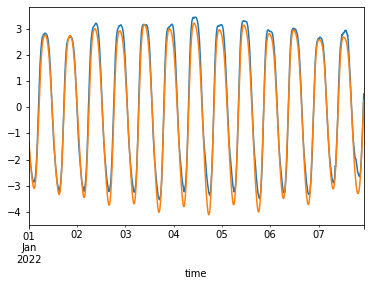

In [47]:
df["sea_level_tide"] = df.ts.tidal_predict("sea_level")

sl = slice(0,1000)
#sl = slice(0,None)

df["sea_level"].iloc[sl].plot()
df["sea_level_tide"].iloc[sl].plot()

In [50]:
# store
dsr.to_netcdf(os.path.join(cp.pathp, f'sea_level.nc'), mode="w")

In [ ]:
---

## bouées

In [58]:
b_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters1/coriolis"

file = os.path.join(b_dir, "mooring-buoys-time-series-6200310.nc")
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                          (N_PROF: 28845, N_PARAM: 17, N_LEVELS: 1, N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/148)
    DATA_TYPE                        object ...
    FORMAT_VERSION                   object ...
    HANDBOOK_VERSION                 object ...
    REFERENCE_DATE_TIME              object ...
    DATE_CREATION                    object ...
    DATE_UPDATE                      object ...
    ...                               ...
    HISTORY_ACTION                   (N_HISTORY, N_PROF) object ...
    HISTORY_PARAMETER                (N_HISTORY, N_PROF) object ...
    HISTORY_START_PRES               (N_HISTORY, N_PROF) float32 ...
    HISTORY_STOP_PRES                (N_HISTORY, N_PROF) float32 ...
    HISTORY_PREVIOUS_VALUE           (N_HISTORY, N_PROF) float32 ...
    HISTORY_QCTEST                   (N_HISTORY, N_PROF) object ...
Attributes:
    title:                
    institution:          
    source:               Coriolis
    history:              2022-07-17T20:00:15Z creation
    references:           http://www.argodatamgt.org/Documentation
    comment:              
    user_manual_version:  3.03
    Conventions:          Argo-3.0 CF-1.6
    featureType:          trajectoryProfile

---

## old stuff

In [25]:
file = "sonde_benji_13.csv"
file_path = os.path.join(root_dir, file)
df = read_sonde_lern(file_path, stype=1)

['Date', 'Time', 'Site', 'Unit ID', 'User ID', 'ï¿½C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 'DEP m-20H100561']


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

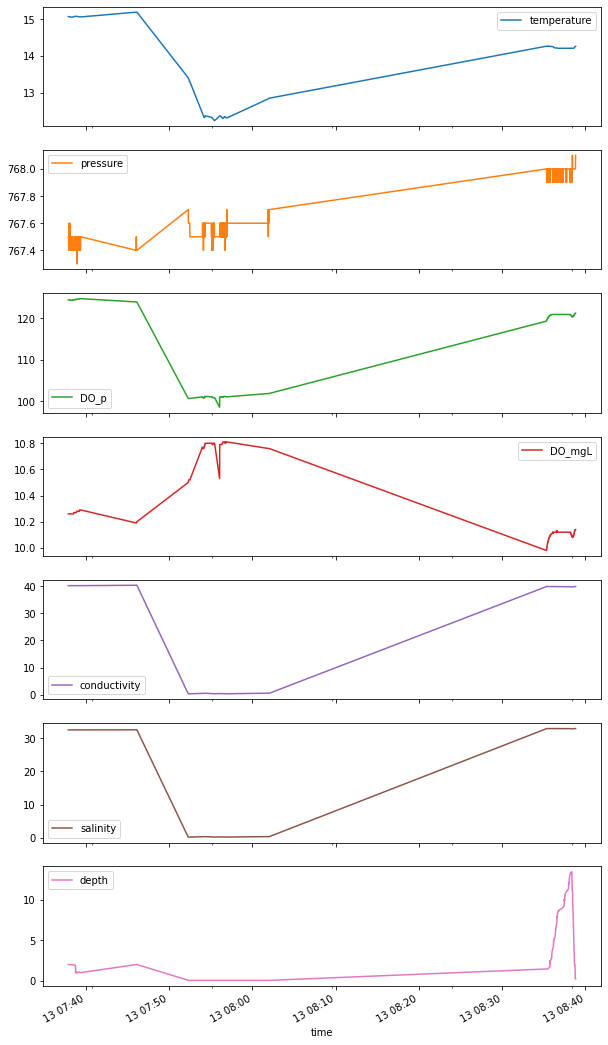

In [26]:
df.plot(subplots=True, figsize=(10,20))